In [1]:
# #once per cluster
# s3helper.open_bucket('mas-dse-open',region='us-west-2')

# info_files=s3helper.ls('Weather/Info')
# Without_path=[x[13:] for x in info_files]


# !mkdir /mnt/workspace/WeatherInfo

# for i in range(len(info_files)-1):   # Last entry is the directory name
#     _from=info_files[i]
#     _to='/mnt/workspace/WeatherInfo/'+Without_path[i]
#     print('From %s to %s'%(_from,_to))
#     s3helper.s3_to_local(_from,_to)
    
# s3helper.open_bucket('dse-weather-west-2', region="us-west-2")
# s3helper.ls('')
# s3helper.s3_to_hdfs("weather.parquet", "/tmp/weather.parquet")
# s3helper.s3_to_hdfs("info/stations.parquet", "/tmp/stations.parquet")
# print(s3helper.ls_hdfs("/tmp"))

In [2]:
import os
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

os.getcwd()
os.chdir("/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis")
os.getcwd()

from Startup import *

finished standard imports
dict_items([('spark.executor.cores', '1'), ('spark.logConf', 'True'), ('spark.app.name', 'Weather_PCA'), ('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.executor.memory', '3g')])
started SparkContext and SQLContext in 14.03 seconds
loaded weather.parquet in 7.53 seconds
loaded stations.parquet in 0.23 seconds
registered dataframes as tables in 0.24 seconds


# Load Data

Here we load the data for the US.  There are a few stations in Canada and Mexico included but shouldn't be a big deal

In [3]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'
"""

print(query)
US_weather_df=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(US_weather_df,'US_weather_df')


SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 128 ms


In [4]:
print('US has %d rows before filter'%(US_weather_df.count()))
US_weather_df.columns

US has 959259 rows before filter


['ID',
 'elevation',
 'state',
 'latitude',
 'longitude',
 'Station',
 'Measurement',
 'Year',
 'Values']

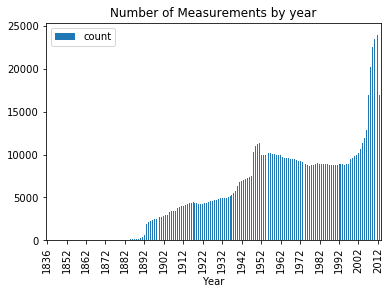

In [5]:
cnt = US_weather_df.groupBy('Year').count()
cnt = cnt.toPandas()
cnt = cnt.sort_values('Year')
ax = cnt.plot.bar('Year', 'count')
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10])
plt.title('Number of Measurements by year')
plt.show()

In [6]:
filter_year = 1945
#Filter for certain dates
US_weather_df = US_weather_df.filter(US_weather_df.Year > filter_year)
print('US has %d rows after filter'%(US_weather_df.count()))

US has 729715 rows after filter


In [7]:
#Filter for only stations with data in the full range
#May or may not be necessary
cnt_bystation = US_weather_df.groupBy('Station').count()
US_weather_df = US_weather_df.join(cnt_bystation, "Station")

In [8]:
mx = cnt_bystation.agg({"count": "max"}).collect()[0]["max(count)"]

In [9]:
US_weather_df = US_weather_df.filter(US_weather_df['count'] == mx)
print('US has %d rows after filter'%(US_weather_df.count()))

US has 118796 rows after filter


In [10]:
US_weather_df.groupby('Year').count().show()

+----+-----+
|Year|count|
+----+-----+
|1959| 1747|
|1990| 1747|
|1975| 1747|
|1977| 1747|
|2003| 1747|
|2007| 1747|
|1974| 1747|
|1955| 1747|
|2006| 1747|
|1978| 1747|
|1961| 1747|
|2013| 1747|
|1952| 1747|
|1956| 1747|
|1988| 1747|
|1997| 1747|
|1994| 1747|
|1968| 1747|
|1951| 1747|
|1973| 1747|
+----+-----+
only showing top 20 rows



# Change from Jan-Jan to Jun-Jun

PRCP data has 365 x 2 = 730 measurements per year so the start of June is at 151 x 2 = 302

In [11]:
def f1(row):
    return row['Values'][:362]

def f2(row):
    return row['Values'][362:]

def Jan2Jun(df):
    df_first = df.copy()
    
    # df_first is same as df except for its ['Values'] column only contains the 
    # the first half year data.
    df_first['V_first'] = df_first.apply(f1, axis=1)
    
    # subtract df_first 'Year' column by 1, because we want to join originally 1998 Jan-Jun to 1997 July-Dec,
    # as 1997 data, so minus 1998 by 1 to match 1997.
    df_first['Year'] = df_first.apply(lambda x: x['Year']-1, axis=1)
    
    # df_second is same as df except for its ['Values'] column only contains the 
    # the second half year data.
    df_second = df.copy()
    df_second['V_second'] = df_second.apply(f2, axis=1)
    
    # drop the inrrelevant columns of df_second so that join can be easier later. I only kept 'ID' and 'Year'
    # that are used to be joined on later.
    df_second = df_second.drop(['elevation', 'state', 'Station',
                                'Measurement', 'Values', 'latitude',
                                'longitude', 'count'], axis=1)
    
    # join df_first and df_second on ID, Year.
    result = pd.merge(df_first, df_second, on=['ID', 'Year'], how='inner')
    
    # generate the thansformed data, e.g. 1997 July - 1998 June from 'V_second' (1997 July - 1997 Dec) and 
    # 'V_first' (1998 Jan - 1998 June)
    result['Values'] = result.apply(lambda x: x['V_second'] + x['V_first'], axis=1)
    
    # drop V_second and V_first as they are useless now.
    return result.drop(['V_second', 'V_first'], axis=1)

US_weather_pdf = US_weather_df.toPandas()
US_weather_pdf = Jan2Jun(US_weather_pdf)

In [12]:
US_weather_pdf.head()

,Station,ID,elevation,state,latitude,longitude,Measurement,Year,Values,count
0,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1946,"[0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...",68
1,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1947,"[32, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, ...",68
2,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1948,"[0, 0, 0, 0, 0, 0, 0, 0, 96, 85, 0, 0, 176, 92...",68
3,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1949,"[0, 0, 0, 0, 128, 75, 32, 88, 104, 89, 0, 0, 9...",68
4,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1950,"[0, 0, 0, 0, 0, 0, 32, 87, 0, 0, 0, 0, 0, 0, 0...",68


In [13]:
US_weather_df = sqlContext.createDataFrame(US_weather_pdf)

# Do calculations

Here we calculate the anomaly per station per year.  Anom_mean refers to the anomaly over the average rainfall for a given year while Anom_sum refers to the anomaly of the total rainfal. 

In [14]:
def get_sum(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nansum(row))
    if ~np.isfinite(row): return 0
    return row

def get_mean(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nanmean(row))
    if ~np.isfinite(row): return 0
    return row

my_sum = F.UserDefinedFunction(get_sum, T.DoubleType())
my_mean = F.UserDefinedFunction(get_mean, T.DoubleType())

US_weather_df = US_weather_df.withColumn('Values_sum', my_sum('Values'))
US_weather_df = US_weather_df.withColumn('Values_mean', my_mean('Values'))

US_weather_df = US_weather_df.filter(US_weather_df.Values_sum != 0)
US_weather_df = US_weather_df.filter(US_weather_df.Values_mean != 0)

In [15]:
avg_sum = US_weather_df.groupby('Station').agg({'Values_sum': 'mean'})
avg_mean = US_weather_df.groupby('Station').agg({'Values_mean': 'mean'})
avg = avg_sum.join(avg_mean, "Station")

In [16]:
a = US_weather_df.alias('a')
b = avg.alias('b')
US_weather_df = a.join(b, "Station")

In [17]:
US_weather_df = US_weather_df.drop('Values', 'ID')

In [18]:
US_weather_df = US_weather_df.withColumn('Anom_sum', F.col('Values_sum')-F.col('avg(Values_sum)'))
US_weather_df = US_weather_df.withColumn('Anom_mean', F.col('Values_mean')-F.col('avg(Values_mean)'))

# Anomaly by Station

In [19]:
# data gives Anom_mean and Anom_sum per station per year.  Lat/Long given
US_weather_df = US_weather_df.drop('avg(Values_sum)', 'avg(Values_mean)',
                                    'count', 'Measurement', 'Values_sum',
                                    'Values_mean')

In [20]:
US_weather_df.show()

+-----------+---------+-----+--------+---------+----+-------------------+-------------------+
|    Station|elevation|state|latitude|longitude|Year|           Anom_sum|          Anom_mean|
+-----------+---------+-----+--------+---------+----+-------------------+-------------------+
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1946| -1928.119402985074| -5.278218283582092|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1947| -1024.119402985074| -2.809468283582092|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1948|  1039.880597014926|  2.846781716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1949|  2759.880597014926|  7.565531716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1950|   711.880597014926| 1.9405317164179081|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1951|   687.880597014926| 1.8780317164179081|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1952|  2407.880597014926|  6.596781716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1953| -2768.

# Calculate average anomaly per state

In [21]:
State_avg = US_weather_df.groupby('state', 'Year').agg({'Anom_mean': 'mean', 'Anom_sum': 'mean'})

In [22]:
%%time
State_avg.show()

+-----+----+-------------------+--------------------+
|state|Year|      avg(Anom_sum)|      avg(Anom_mean)|
+-----+----+-------------------+--------------------+
|   SD|1971|  760.4416553595657|  2.0835574601689713|
|   SD|2008| 428.25983717774767|  1.1734012101689706|
|   MD|1988|  668.1572139303483|  1.8317552860696522|
|   MO|1975|-1443.4743283582095|   -3.95372658800723|
|   CO|1980| -724.5688573449769| -1.9846790206086864|
|   TX|1974| 2162.2354626865667|   5.923578351142017|
|   TX|1999|-1207.8746311731384|  -3.309290835432101|
|   VA|1976|-1240.8779317697226|  -3.399578558102345|
|   WA|1951| -1493.836177961865|  -4.092833215891982|
|   WA|1972|-1396.0730200671285| -3.8232505678656663|
|   ID|2003| -670.2912397261341|  -1.837029163444661|
|   KY|1996|  3257.965671641791|   8.924821085004664|
|   IN|1964|-1770.8597014925372| -4.8535911749844525|
|   ME|1999| 1420.3482587064677|  3.8953863495024876|
|   QC|2008|-238.25373134328402| -0.6476212686567155|
|   NT|1974|  27.19402985074

In [23]:
pdf = State_avg.filter((F.col("state") == "CA")).toPandas()

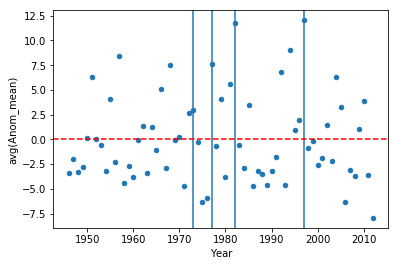

In [24]:
major_elnino = [1973, 1977, 1982, 1997]
pdf.plot.scatter('Year', 'avg(Anom_mean)')
for x in major_elnino: plt.axvline(x)
plt.axhline(0, linestyle = '--', color = 'r')
plt.show()

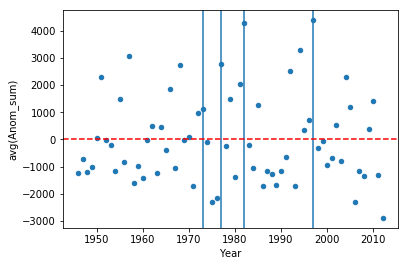

In [25]:
major_elnino = [1973, 1977, 1982, 1997]
pdf.plot.scatter('Year', 'avg(Anom_sum)')
for x in major_elnino: plt.axvline(x)
plt.axhline(0, linestyle = '--', color = 'r')
plt.show()

## State-level Map

In [26]:
df = State_avg.toPandas()

In [27]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
df_ElNinoYears = pd.read_csv(url + '/US_Unemployment_Oct2012.csv')
state_geo = url + '/us-states.json'
county_geo = url + '/us_counties_20m_topo.json'
US_states = list(df_ElNinoYears['State'])
ElNinoYears = [1951, 1957, 1965, 1968, 1972, 1977, 1982, 1991, 1997]

# Drop non US regions
pick = [df['state'][i] in US_states for i in df.index]
df = df[pick]

### Map of 1997

In [28]:
df_1997 = df[df['Year']==1997]
df_1997.index = range(len(df_1997))
df_1997 = df_1997[df_1997['state'] != 'AK']
df_1997 = df_1997[df_1997['state'] != 'HI']

In [29]:
import folium

#bins = list(df_1997['avg(Anom_sum)'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
bins = [-1000, -500, 0, 1000, 2000, 4393]
m = folium.Map(location=[38, -102], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_1997,
    columns=['state', 'avg(Anom_sum)'],
    key_on='feature.id',
    fill_color='RdYlBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Precipitation Anomalies'
).add_to(m)

folium.LayerControl().add_to(m)

save_path = '/mnt/workspace/Public-DSC291/hw3/results/'
m.save(save_path+'PRCP_State_1997.html')
m

** This map is also saved in ./results **

### Average for all El Nino Years

In [30]:
pick = [df['Year'][i] in ElNinoYears for i in df.index]
df = df[pick]
df_ElNinoYears.columns = ['state', 'avg(Anom_sum)']
for i in df_ElNinoYears.index:
    df_ElNinoYears['avg(Anom_sum)'][i] = df[(df['state']==df_ElNinoYears['state'][i])]['avg(Anom_sum)'].mean()

df_ElNinoYears.index = range(len(df_ElNinoYears))

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
bins = [-1000, -500, 0, 500, 1000, 2200]
m = folium.Map(location=[38, -102], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_ElNinoYears,
    columns=['state', 'avg(Anom_sum)'],
    key_on='feature.id',
    fill_color='RdYlBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Precipitation Anomalies'
).add_to(m)

folium.LayerControl().add_to(m)
m.save(save_path+'PRCP_State_ElNinoYears.html')
m

## Region-level Map

In [32]:
US_weather_df = US_weather_df.drop('Station', 'elevation')
US_weather_pdf = US_weather_df.toPandas()
pick = [US_weather_pdf['state'][i] in US_states for i in US_weather_pdf.index]
US_weather_pdf = US_weather_pdf[pick]
US_weather_pdf.head()

,state,latitude,longitude,Year,Anom_sum,Anom_mean
0,AR,34.5128,-93.0486,1946,-1928.119403,-5.278218
1,AR,34.5128,-93.0486,1947,-1024.119403,-2.809468
2,AR,34.5128,-93.0486,1948,1039.880597,2.846782
3,AR,34.5128,-93.0486,1949,2759.880597,7.565532
4,AR,34.5128,-93.0486,1950,711.880597,1.940532


In [33]:
import urllib
import branca
import json
import requests
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Get FIPS code with this function

def getFIPS(lat, lon):
    url = urllib.request.urlopen("https://geo.fcc.gov/api/census/area?lat=" 
                                 + str(lat) + "&lon=" + str(lon) + "&format=json")
    data = json.loads(url.read().decode())
    FIPS = data['results'][0]['county_fips']
    return FIPS

FIPS_dict = dict()
FIPS = []
for i in US_weather_pdf.index:
    lat = US_weather_pdf['latitude'][i]
    lon = US_weather_pdf['longitude'][i]
    if (lat, lon) in FIPS_dict:
        FIPS.append(FIPS_dict[(lat, lon)])
    else:
        FIPS_code = getFIPS(lat, lon)
        FIPS.append(FIPS_code)
        FIPS_dict[(lat, lon)] = FIPS_code
    
US_weather_pdf['FIPS'] = FIPS
US_weather_pdf = US_weather_pdf[['FIPS','Year','Anom_sum']]
US_weather_pdf.sample(5)

,FIPS,Year,Anom_sum
96297,31185,1961,-954.029851
111552,06023,1951,3291.432836
54328,29023,1964,1706.313433
51731,06111,1979,2545.253731
28455,06037,2009,309.761194


### Map of 1997

In [34]:
region_df_1997 = US_weather_pdf[US_weather_pdf['Year']==1997]
region_df_1997.index = range(len(region_df_1997))
region_df_1997['FIPS'] = [int(x) for x in region_df_1997['FIPS']]

FIPS_set = set(list(region_df_1997['FIPS']))
series_data = []
for fips in FIPS_set:
    series_data.append(region_df_1997[region_df_1997['FIPS'] == fips]['Anom_sum'].mean())
    
region_sr_1997 = pd.Series(data=series_data, index=list(FIPS_set))

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [61]:
colorscale = branca.colormap.linear.RdYlBu_05.scale(-2000, 4000) 
colorscale.caption = 'Pricipitation Anomalies'

last_color = '#ffffff'
def style_function(feature):
    global last_color
    prcp = region_sr_1997.get(int(feature['id'][-5:]), None)
    color = last_color
    if prcp:
        color = colorscale(prcp)
        last_color = color
    return {
        'fillOpacity': 0.7,
        'weight': 0,
        'fillColor': color
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3,
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colorscale)
m.save(save_path + 'PRCP_Region_1997.html')

m

### Average for all El Nino years

In [36]:
pick = [US_weather_pdf['Year'][i] in ElNinoYears for i in US_weather_pdf.index]
region_df_EN = US_weather_pdf[pick]
region_df_EN.index = range(len(region_df_EN))
region_df_EN['FIPS'] = [int(x) for x in region_df_EN['FIPS']]

FIPS_set = set(list(region_df_EN['FIPS']))
series_data = []
for fips in FIPS_set:
    series_data.append(region_df_EN[region_df_EN['FIPS'] == fips]['Anom_sum'].mean())
    
region_sr_EN = pd.Series(data=series_data, index=list(FIPS_set))

/mnt/anaconda/envs/ipykernel_py34/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
colorscale = branca.colormap.linear.RdYlBu_05.scale(-1000, 2000) 
colorscale.caption = 'Pricipitation Anomalies'

last_color = '#ffffff'
def style_function(feature):
    global last_color
    prcp = region_sr_EN.get(int(feature['id'][-5:]), None)
    color = last_color
    if prcp:
        color = colorscale(prcp)
        last_color = color
    return {
        'fillOpacity': 0.7,
        'weight': 0,
        'fillColor': color
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3,
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)

m.add_child(colorscale)
m.save(save_path + 'PRCP_Region_EN.html')

m